# Model A: Premium Health Insurance Prediction (Age <= 25)

In this notebook, we will focus on developing **Model A**, which will be trained on the dataset for individuals **aged 25 and under**. This age group showed higher error rates in the previous analysis, so our goal is to address those errors and improve the model's predictions for this subset.

### Objectives:
- Train and evaluate a machine learning model for predicting health insurance premiums for individuals aged 25 and under.
- Focus on improving model performance for this age group and reducing the error rate.

Let's begin by importing the necessary libraries and loading the dataset for this age group.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.metrics import r2_score



In [85]:
df=pd.read_excel("premiums_young.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [86]:
df.shape

(20096, 13)

### 🧹 **Data Cleaning Process:**

To ensure our dataset is ready for analysis, we need to perform some **data cleaning** tasks. This involves:

1. **Column Name Cleaning**: Ensure column names are in a consistent format.
2. **Handling Negative Values**: Investigating and fixing negative values in the "Number of Dependants" column.
3. **Descriptive Statistics**: Generating a summary of the data for better understanding.

Let’s dive into the steps!


In [87]:
# Cleaning up column names by replacing spaces with underscores for consistency
df.columns=df.columns.str.replace(" ","_").str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

#### 1. **Column Name Cleaning**:
We started by cleaning the column names. Spaces in column names were replaced with underscores to maintain consistency and make it easier to work with. This step helps prevent potential issues when referencing columns in the future.


In [88]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20096.000000,20096.000000,20096.000000,20096.000000
mean,21.494029,0.718004,22.506519,8141.941033
std,2.294050,0.940767,23.418644,2749.609551
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,21.500000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


#### 2. **Why  Negative Values in 'Number of Dependants' ?**:
As we review the data, we notice some negative values in the **"Number_Of_Dependants"** column. Let’s explore this part further to understand the extent of the issue.


In [89]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [90]:
df=df.dropna()
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [91]:
# Checking the rows where the 'Number_Of_Dependants' column has negative values
df[df["number_of_dependants"]<0].shape

(22, 13)

In [92]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-3, -1], dtype=int64)

#### 3. **Handling Negative Values**:
Upon investigation, we find that there are **72 rows** with negative values in the "Number_Of_Dependants" column. However, **only two unique values** are causing the issue. Instead of deleting all these rows, which could result in losing useful data, we decide to correct the values by changing them to positive values.
- We could contact the data creators to clarify if these values are errors. However, for this analysis, we'll proceed by converting these negative values into their absolute values to retain the data.


In [93]:
# Converting negative values in 'Number_Of_Dependants' to positive
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

## 🔍 **Outlier Treatment:**

In [94]:
numerical_columns=df.select_dtypes(["float64",'int64']).columns.tolist()
numerical_columns


['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

In [95]:
def format_ticks(value, _):
    return f"{int(value/1000)}K" if value >= 1000 else str(int(value))

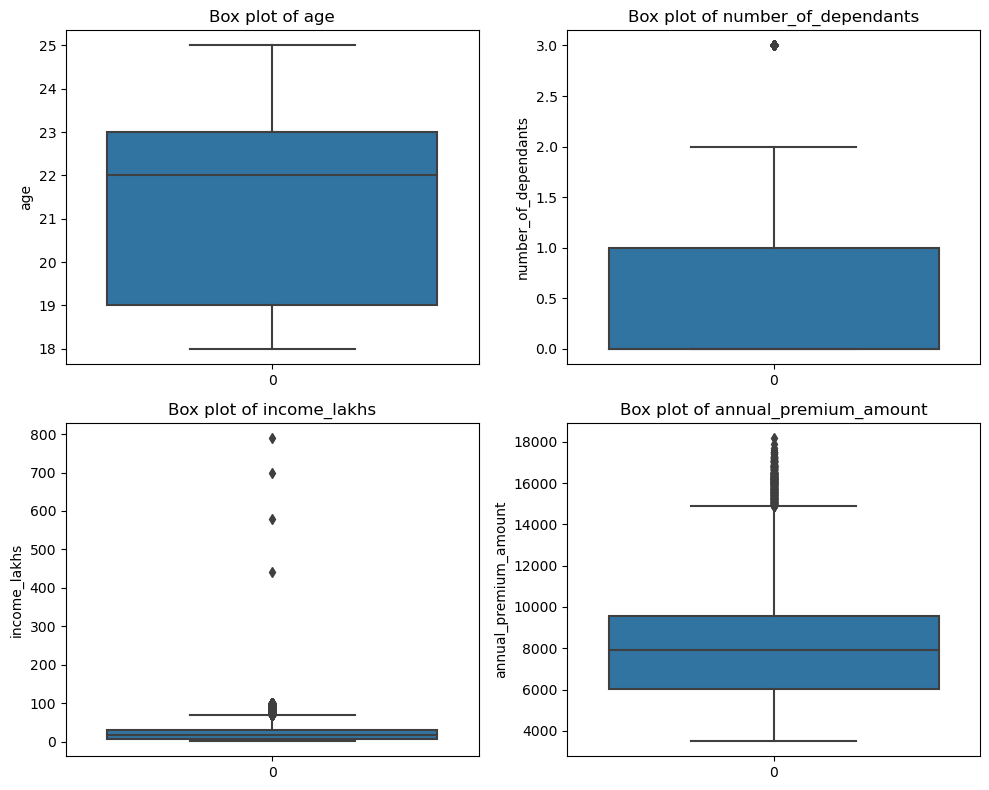

In [96]:
num_cols=len(numerical_columns)
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.boxplot(data=df[col], ax=ax)
    ax.set_title(f'Box plot of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()
    

    
    

### 📊 **Boxplot Insights:**

The boxplots reveal some interesting trends:

- 🧑‍🤝‍🧑 **Age & Income**: Both columns show noticeable **outliers**. These could be worth investigating further! 🚨
- 💳 **Premium Amount**: Only a few outliers here, but they’re pretty insignificant. Let’s just **ignore** them for now. 🧹


## 🧑‍⚖️ **Age Column Cleaning**:

In the **Age** column, we noticed some entries above 100 years. Let's take a closer look at these extreme values.

In [97]:
## age column 
df[df["age"]>100]["age"].unique()


array([], dtype=int64)

In [98]:
## remove those whose age is greater than 100

df1=df[df["age"]<=100].copy()
df1.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [99]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


## 💸 **Income Column Cleaning**:

In this section, we will clean the **Income_Lakhs** column by handling outliers based on the **Interquartile Range (IQR)** method, and further adjust the threshold as needed.

---

## 🔍 **Defining IQR Bounds**:

To detect outliers, we first calculate the **Interquartile Range (IQR)**. This helps us identify the bounds within which most of the data lies.


In [100]:
## lets treat the income column
## defining iqr bounds

def get_iqr_bounds(col):
    Q1,Q3=col.quantile([0.25,0.75])
    iqr=Q3-Q1
    lower_bound=Q1-1.5*iqr
    upper_bound=Q3+1.5*iqr
    return lower_bound,upper_bound
    

In [101]:
get_iqr_bounds(df["income_lakhs"])

(-31.5, 68.5)

### 🧠 Reassessing the Upper Bound:
After reviewing the results, we found that the upper bound of the **Income_Lakhs** column is **67 lakhs**, which is common in today's context.
To make this more relevant, we will increase the **threshold** to **1 crore (100 lakhs)**, which seems like a more reasonable upper limit.

In [102]:
## I think one crore would be a best threshold for this senario

quantile_threshold=df["income_lakhs"].quantile(0.999)
quantile_threshold

100.0

### 📊 Identifying Outliers Above the Threshold:
Let’s see how many rows have income values exceeding this new threshold.

In [103]:
## lets analyse how many more rows we have more than this threshold

df[df["income_lakhs"]>quantile_threshold].shape


(4, 13)

### 🧹 Cleaning the Income Column:
Since there are only a few rows with values above the threshold, we will drop them to ensure the data stays within a reasonable range.

In [104]:
## since there are few values only lets drop those 
df2=df1[df1["income_lakhs"]<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


### 📊 **Univariate Analysis**:

In this section, we will explore the distribution of the numeric columns in our cleaned dataset through **histograms** with **KDE** (Kernel Density Estimate) overlays. This will help us understand the spread and shape of the data.

---

### 👀 **Visualizing the Distribution of Numeric Columns**:

We will use **histograms** to visualize the frequency distribution of each numeric column, with an added **KDE** to provide a smoother estimate of the distribution. This will allow us to observe patterns like skewness, central tendency, and any potential outliers.


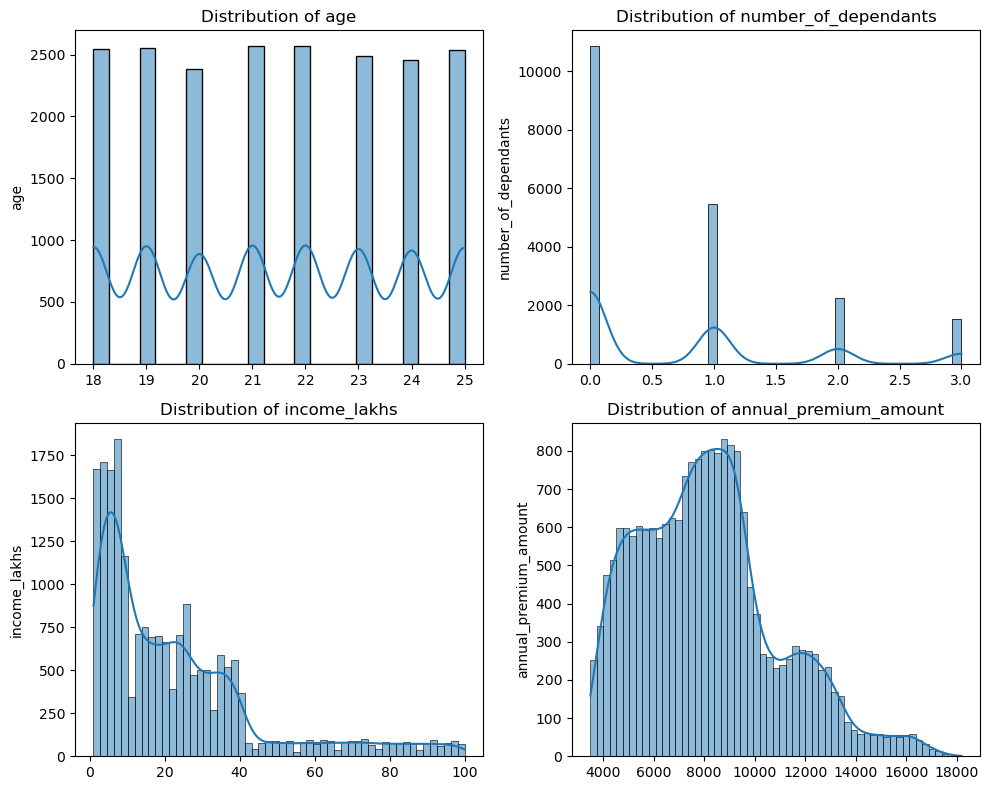

In [105]:
## visulaise the distribution of the numeric columns

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.histplot(data=df2[col], ax=ax,kde=True)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)
    # Apply y-tick formatting only for "income" column

plt.tight_layout()
plt.show()
    

### 🚀 Insights:

#### 1. 🧑‍🤝‍🧑 **Age Distribution**:
Looks like **most applicants** are in the **up-to-60 years** age range. 👴👵 (The majority are still in their prime!)

#### 2. 👨‍👩‍👧‍👦 **Number of Dependents**:
Surprisingly, **zero dependents** is the most common! 💯 (Guess it’s a no-kids or single-life vibe!)

#### 3. 💸 **Income Distribution**:
**Right-skewed** alert! 🚨 Most applicants are in the **up-to-40 lakh** range. Guess that’s where the money’s at? 💰

#### 4. 💳 **Annual Premium Amount**:
Another right-skewed situation! 🚀 **Most applicants** are chilling in the **10K premium range**. Keep it cool, keep it affordable! 😎


### 📊 Bivariate Analysis

---

#### Numeric columns

In [106]:
numeric_features=numerical_columns.copy()
numeric_features.remove("annual_premium_amount")
numeric_features

['age', 'number_of_dependants', 'income_lakhs']

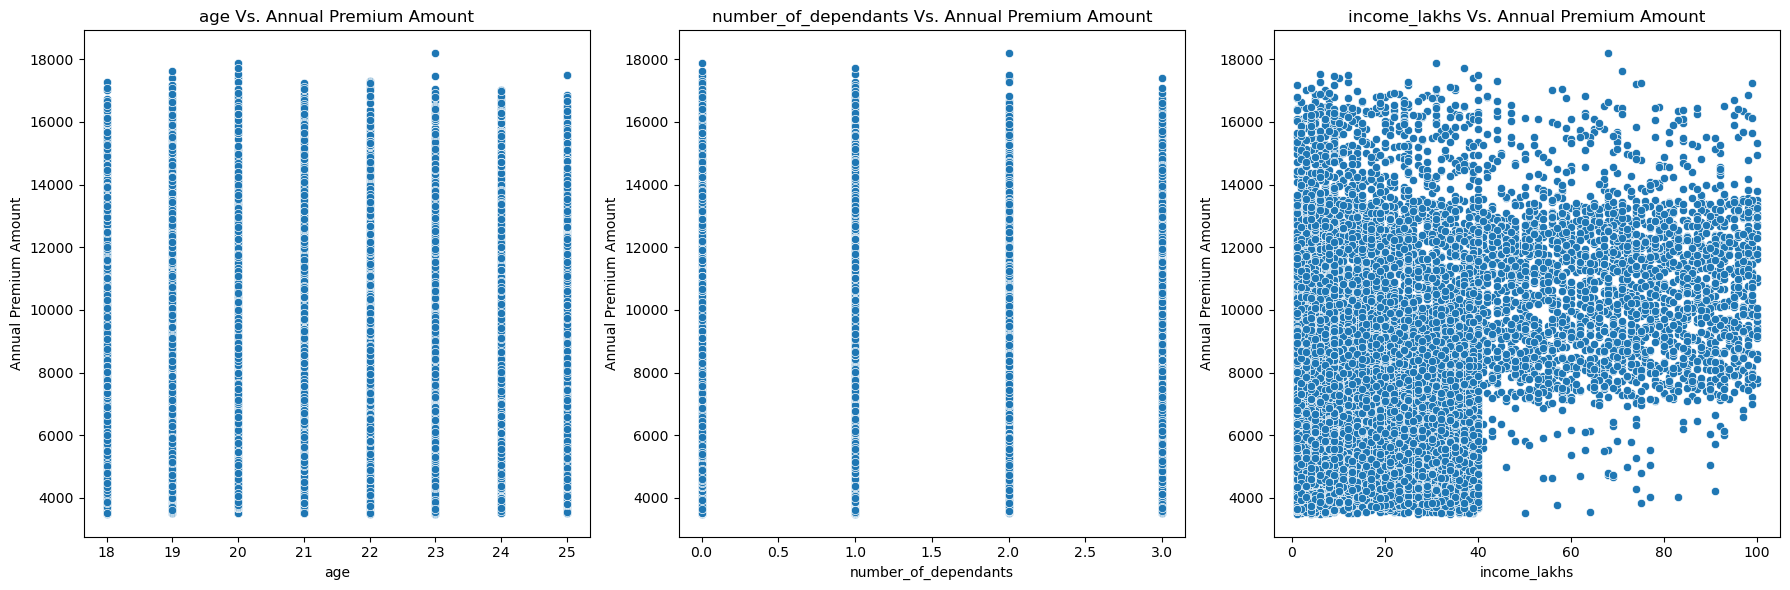

In [107]:
fig, axes=plt.subplots(1,len(numeric_features),figsize=(18,6))
for ax , col in zip(axes , numeric_features):
    sns.scatterplot(x=df2[col],y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f'{col} Vs. Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annual Premium Amount')
plt.tight_layout()
plt.show()

### Categorical Columns

In [108]:
categorical_columns=df.select_dtypes(["object"]).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [109]:
## lets check the categorical columns
for col in categorical_columns:
    print(f'{col}:{df2[col].unique()}')
    print()

gender:['Male' 'Female']

region:['Northeast' 'Northwest' 'Southeast' 'Southwest']

marital_status:['Unmarried' 'Married']

bmi_category:['Overweight' 'Underweight' 'Normal' 'Obesity']

smoking_status:['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']

employment_status:['Self-Employed' 'Freelancer' 'Salaried']

income_level:['> 40L' '<10L' '10L - 25L' '25L - 40L']

medical_history:['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']

insurance_plan:['Silver' 'Bronze' 'Gold']



In [110]:
## Looks like the values in smoking status are not good lets fix them:
df2['smoking_status'].replace(
    {
        'Smoking=0':'No Smoking',
        'Does Not Smoke':"No Smoking",
        'Not Smoking':"No Smoking"
    }
    ,inplace=True
)
df2["smoking_status"].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [111]:
pct_counts=df2['gender'].value_counts(normalize=True)
pct_counts

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

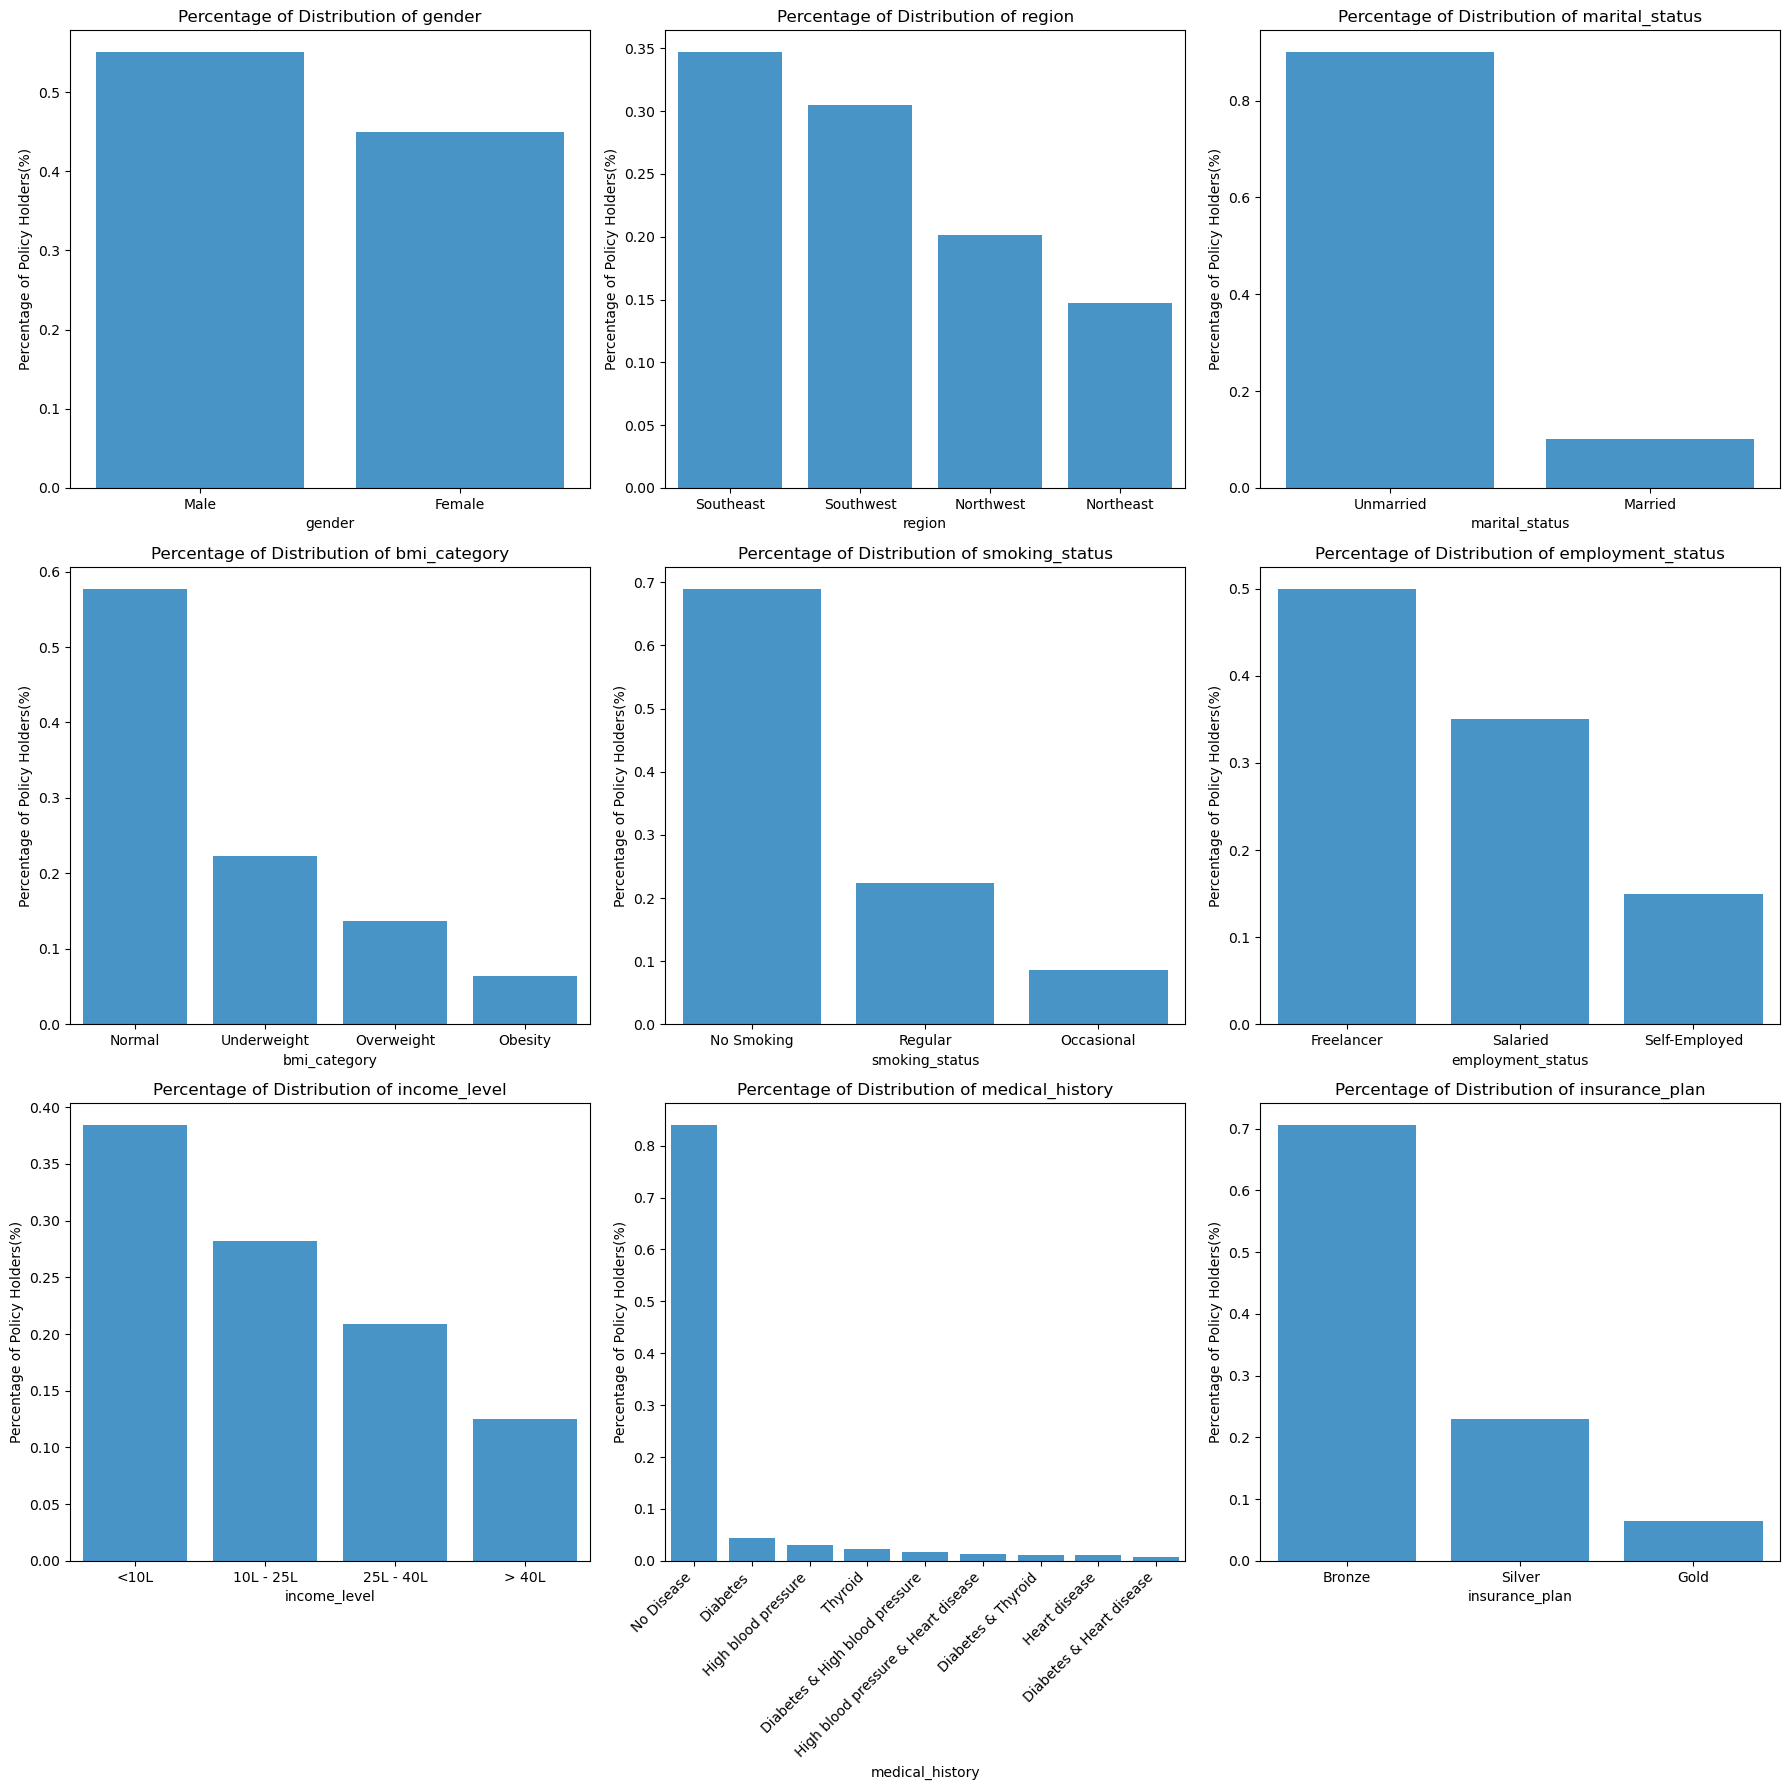

In [112]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    category_counts=df2[col].value_counts(normalize=True)
    
    #creating bar plots
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax,color=bar_color)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    # Rotate x-axis labels if there are too many
    if len(category_counts) > 8:  
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 🧐 **Insights**

Based on the analysis, the following key insights have been identified:

---

### 👨‍💼 **Male Policyholders Outnumber Female Policyholders**
- There is a slight difference in the number of male policyholders compared to female policyholders, with males holding a majority.

### 🌍 **Regional Performance**
- The **Southeast** region stands out as the top-performing region, while the **Northeast** region has the least number of policyholders.

### 💍 **Marital Status Insights**
- **Unmarried policyholders** outnumber married ones, although the difference is quite small.

### 🏋️‍♀️ **BMI Insights**
- A significant proportion of policyholders fall under the **Normal BMI** category, standing out compared to other BMI categories.

### 🚭 **Smoking & Medical History**
- Policyholders with **no smoking habits** and **no disease medical histories** represent the majority, making these groups the most common among all categories.

### 💼 **Income and Employment Insights**
- A large number of policyholders are **salaried individuals** with an annual income **below 10 lakhs**, which is the most common demographic in the data.

### 🥇 **Plan Preferences**
- Most policyholders have opted for the **Bronze** insurance plan. This suggests that the company may benefit from running a campaign to encourage customers to consider upgrading to **Silver** or **Gold** plans, offering more comprehensive coverage.

---

These insights highlight trends and patterns that can inform future decision-making, marketing strategies, and customer engagement for insurance providers. 🚀


### lets include add a legend insurance plan to get better understanding of each categorical variable

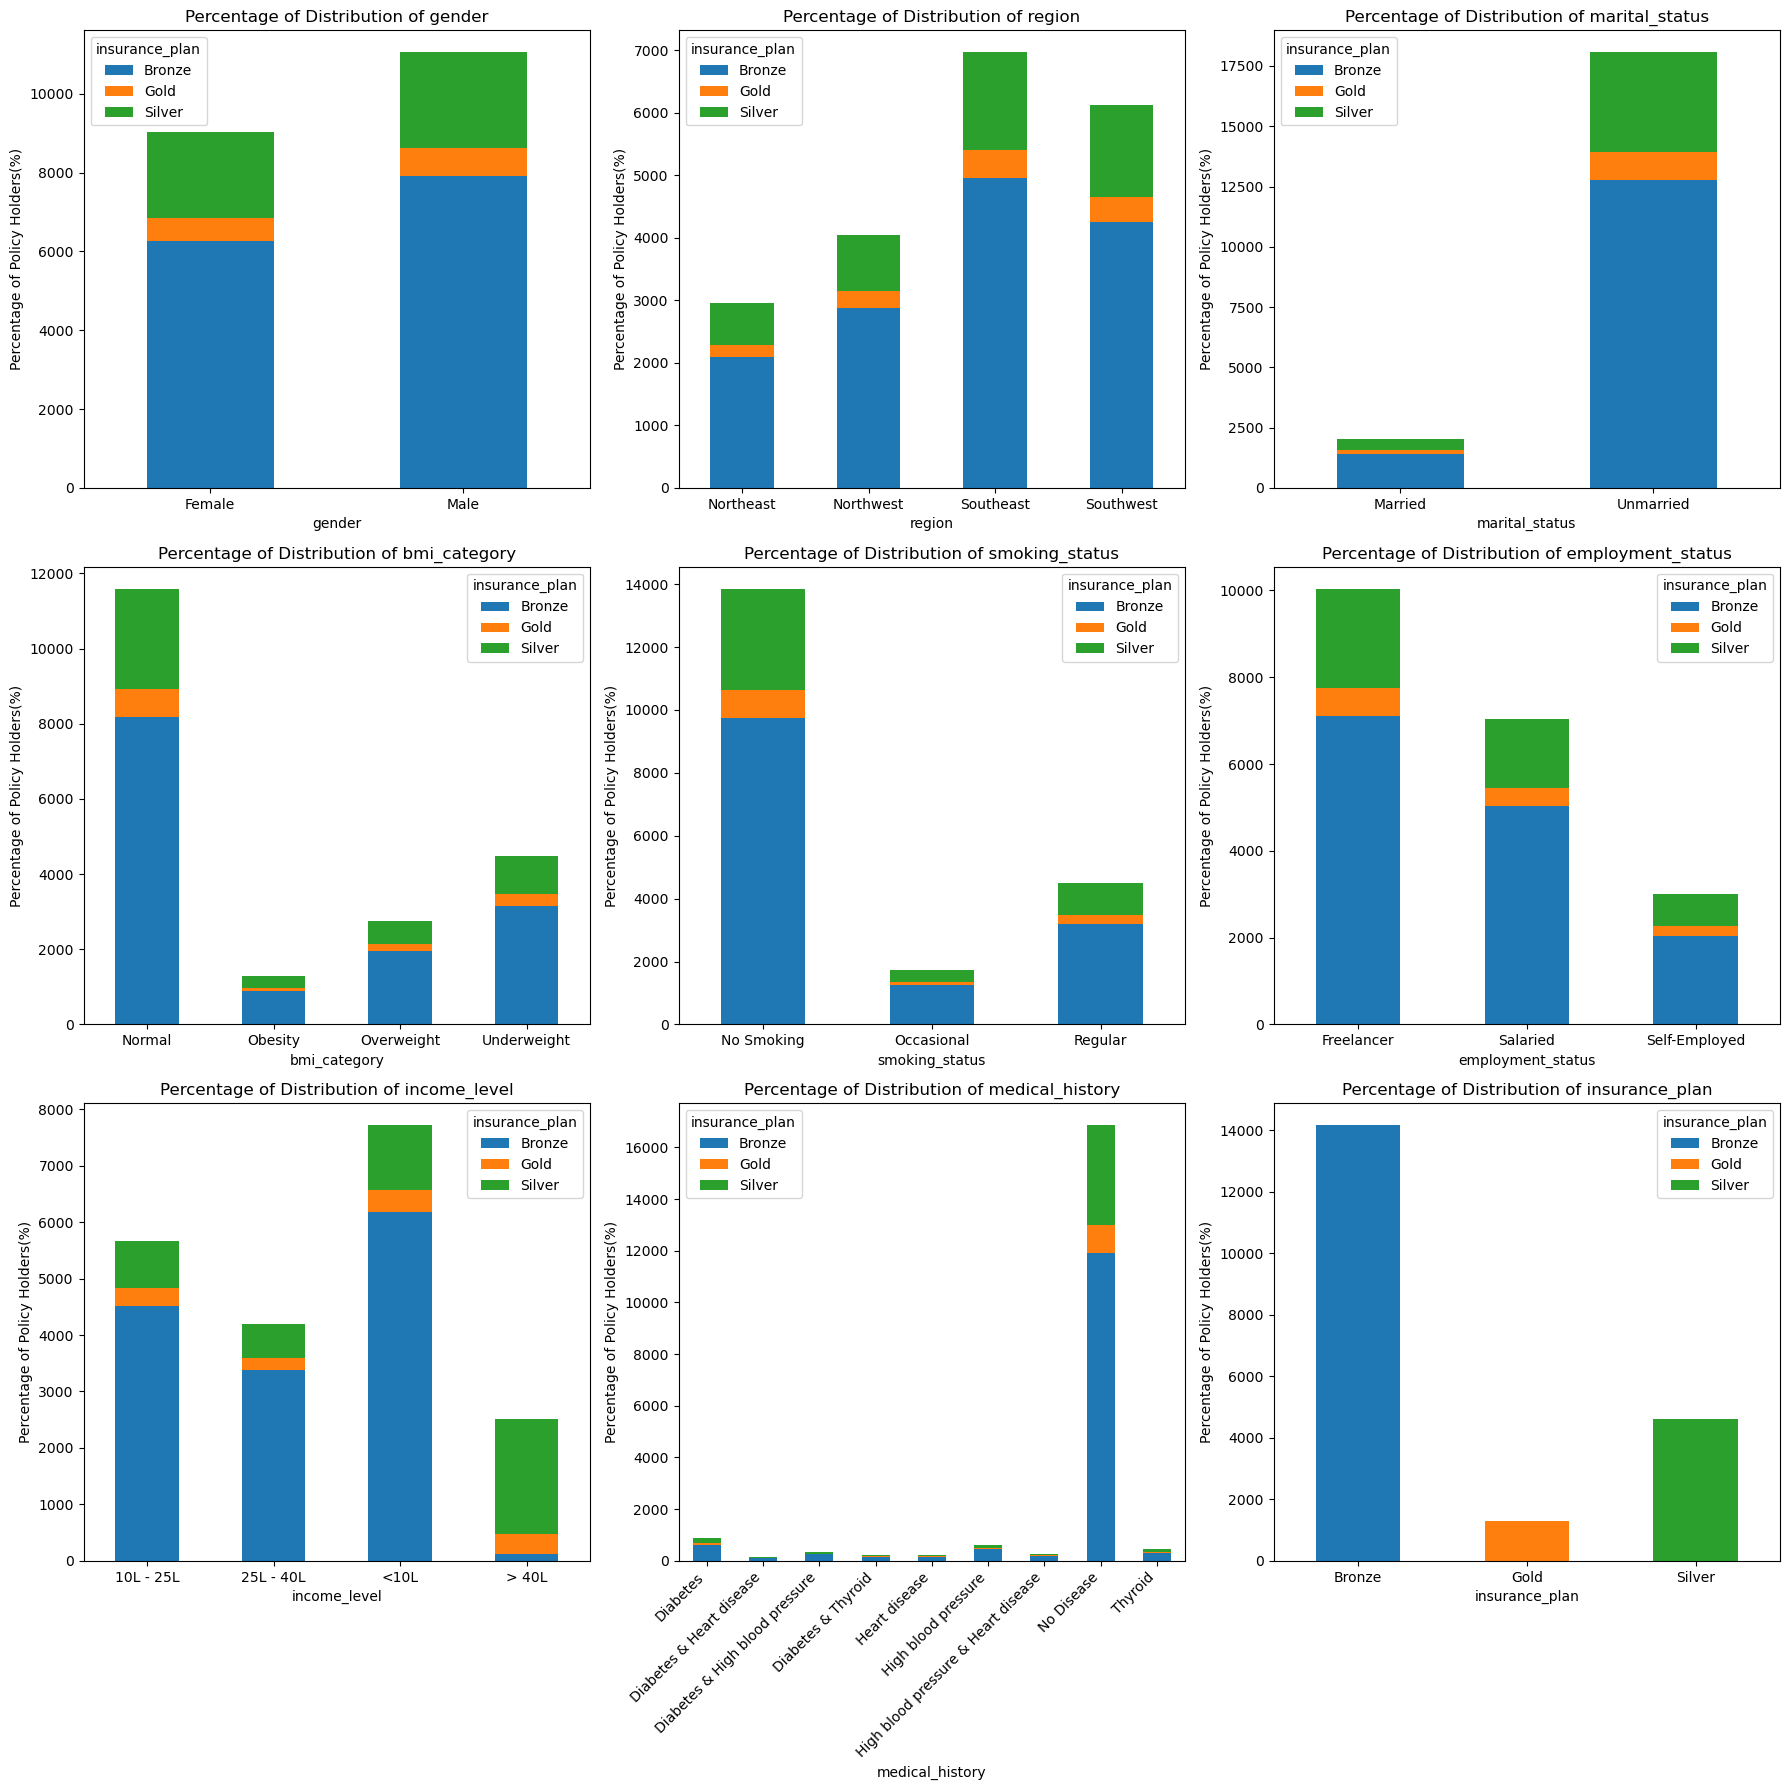

In [113]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    cross_tab=pd.crosstab(df2[col],df2['insurance_plan'])

    #creating bar plots
    cross_tab.plot(kind="bar",ax=ax,stacked=True)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    
    # Rotate x-axis labels if there are too many
    if len(cross_tab) > 7:   
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

## Feature Enginnering


In [114]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [115]:
## we have more than one values as disease column
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

### Calculating the Risk Score Using the `medical_history` Column

Intuitively, as the number of diseases increases, the insurance amount also tends to increase. To quantify this relationship, we define a **risk score** that helps assess the likelihood of higher medical risks.

After consulting with the business team, the following risk indices were determined for specific medical conditions:

```json
{
  "diabetes": 6,
  "high_blood_pressure": 6,
  "heart_disease": 8,
  "thyroid": 5,
  "no_disease": 0,
  "none": 0
}


In [116]:
risk_scores={
  "diabetes": 6,
  "high blood pressure": 6,
  "heart disease": 8,
  "thyroid": 5,
  "no disease": 0,
  "none": 0
}

In [117]:
# lets split the medical_history column into two columns
# converting to lower case and adding to the dataframe

df2[['disease1','disease2']]=df2['medical_history'].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,None


In [118]:
# filling the null values with none
df2.disease1.fillna('none',inplace=True)
df2.disease2.fillna('none',inplace=True)
df2['total_risk_score']=0

# updating the risk score
for disease in ['disease1','disease2']:
    df2['total_risk_score']+=df2[disease].map(risk_scores)

#normalising the risk score
max_score=df2['total_risk_score'].max()
min_score=df2['total_risk_score'].min()
df2['normalized_risk_score']=(df2['total_risk_score']-min_score)/(max_score-min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


### Label encoding for Ordinal Columns

In [119]:
# insurance plan
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':0,'Silver':1,'Gold':2})
df2.insurance_plan.unique()

array([1, 0, 2], dtype=int64)

In [120]:
# lets label encode income level also 
df2['income_level']=df2['income_level'].map({'<10L':0,'10L - 25L':1,'25L - 40L':2,'> 40L':3})
df2.income_level.unique()

array([3, 0, 1, 2], dtype=int64)

### Lets handle nominal columns (OneHot-Encoding)

In [121]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,1,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,0,3,No Disease,1,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,3,97,No Disease,1,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,1,15,No Disease,0,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,1,14,No Disease,0,5712,no disease,none,0,0.000000


In [122]:
nominal_cols=['gender','region','marital_status','bmi_category','smoking_status','employment_status']
df3=pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,High blood pressure,1,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,0,3,No Disease,1,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,No Disease,1,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,1,15,No Disease,0,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,1,14,No Disease,0,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [123]:
df4=df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,1,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,0,3,1,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,1,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,1,15,0,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,1,14,0,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Correlation Matrix Heatmap
-To visualize the correlation between different features in the dataset, we use a **heatmap**. This helps in identifying   
highly correlated features, which can be removed to reduce multicollinearity.

-The heatmap provides a clear view of relationships between features, aiding in better feature selection.

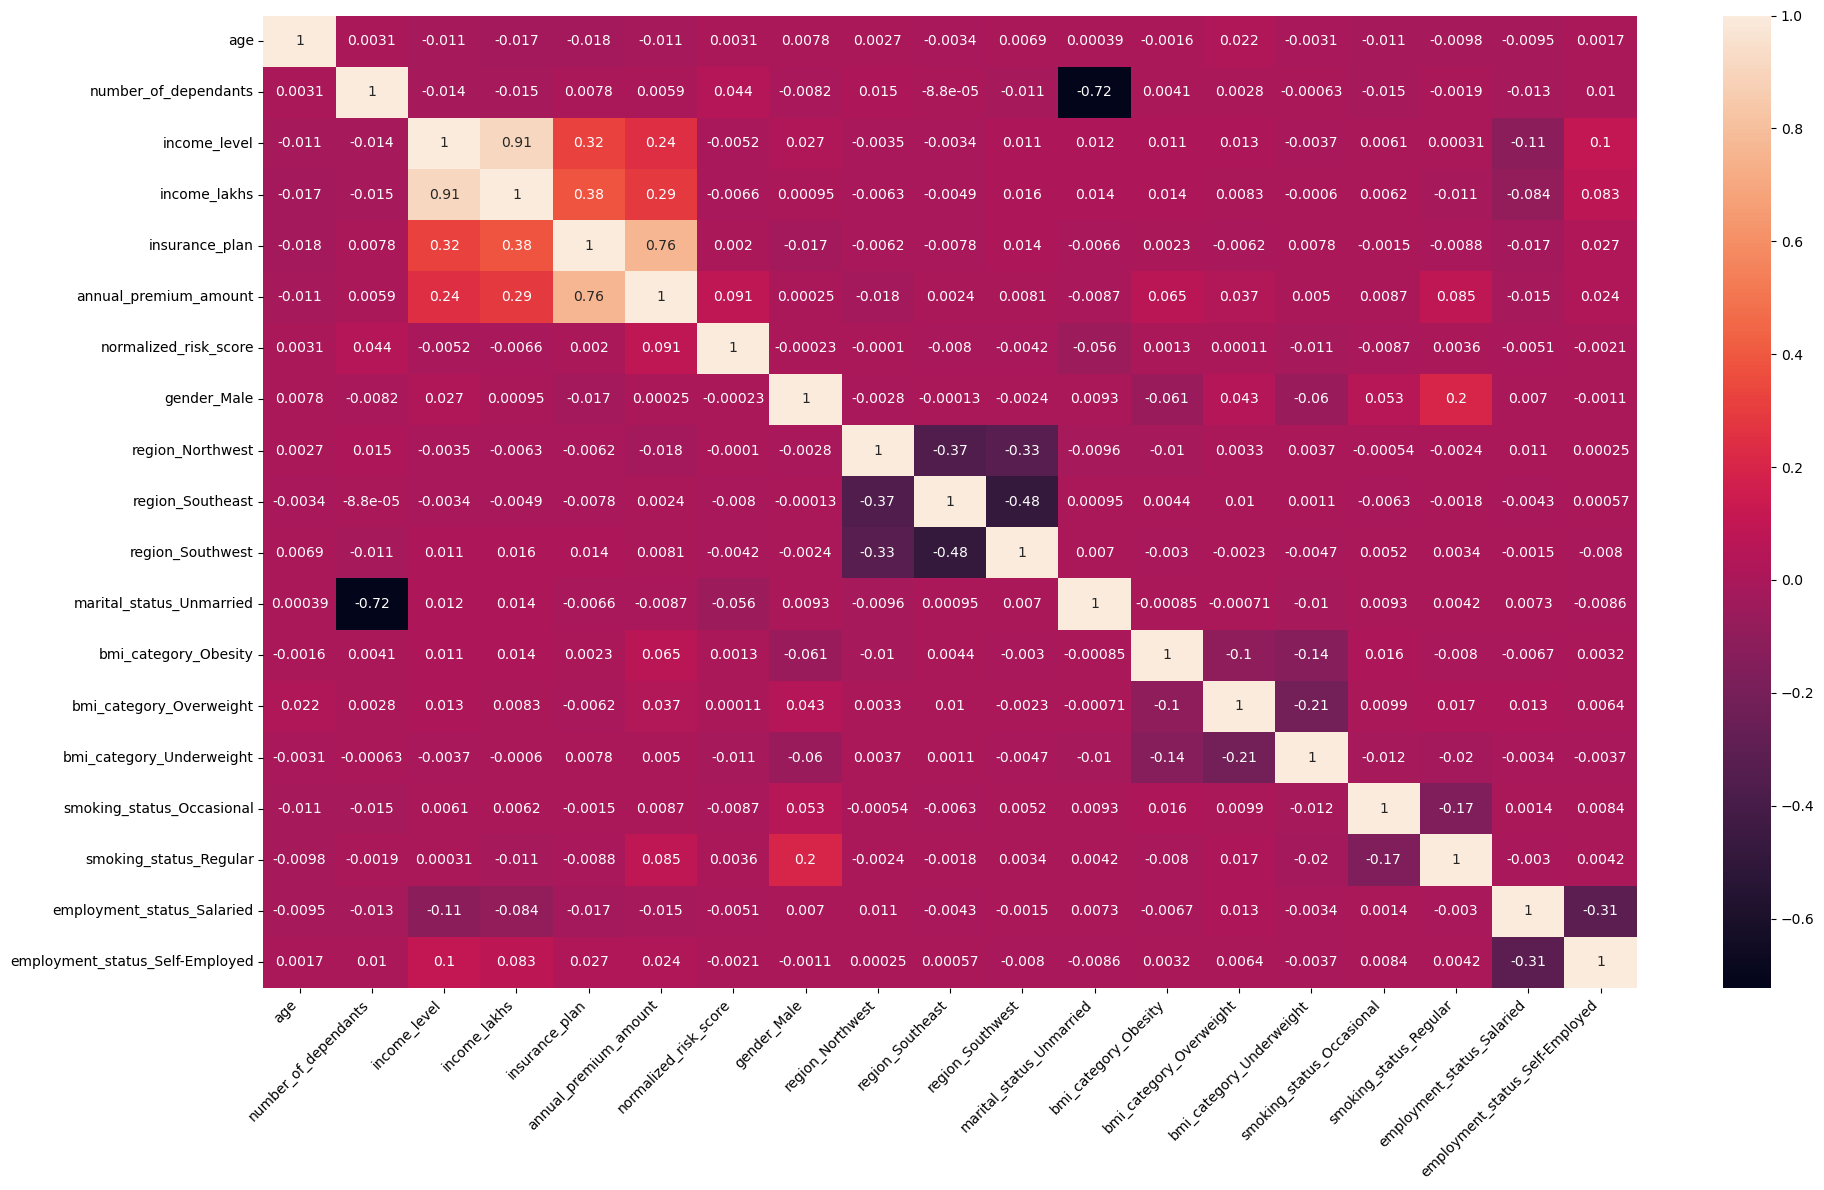

In [124]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

### Feature Scaling

In [125]:
X=df4.drop("annual_premium_amount",axis='columns')
y=df4['annual_premium_amount']

cols_to_scale=['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler()
X[cols_to_scale]=scalar.fit_transform(X[cols_to_scale])
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection Using Correlation Matrix and VIF

Feature selection is crucial for building an efficient machine learning model. One way to choose features is by using a **correlation matrix**, where highly correlated features can be removed to avoid multicollinearity.

However, a better approach is to use **Variance Inflation Factor (VIF)**.

### Variance Inflation Factor (VIF)
VIF helps in identifying multicollinearity by measuring how much the variance of a regression coefficient is inflated due to collinearity among features. Unlike correlation, VIF evaluates the relationship of one feature with all other features in an aggregate way, making it a more reliable method for feature selection.


In [126]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['variable']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data,i) for i in range(data.shape[1])]
    return vif_df

In [127]:
calculate_vif(X)

,variable,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


### Handling Multicollinearity Using VIF

- A **VIF (Variance Inflation Factor) value greater than 10** indicates high multicollinearity between features.
- In our case, **`income_level`** and **`income_lakhs`** have high VIF values, suggesting strong correlation.
- Since these features are essentially conveying the same information, it is best to remove the feature with the highest VIF.
- After removing the feature with the highest VIF, we **recalculate VIF values** to ensure multicollinearity is minimized.

This iterative process helps in selecting the most independent features, leading to a more stable and interpretable model.


In [128]:
calculate_vif(X.drop("income_level",axis='columns'))

,variable,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [129]:
X_reduced=X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


## Model Training

In [130]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.3,random_state=41)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_train.shape}')

X_train : (14060, 17)
X_test : (6026, 17)
y_train : (14060,)
y_test : (14060,)


### Training the Linear Regression Model

We have trained the **Linear Regression** model for the **young age group (Age <= 25)**. The model has been evaluated on both the **training set** and the **test set**.

### Results:
- **Training Score**: 0.6067
- **Test Score**: 0.5938

### Key Insights:
- The training and test scores are fairly close, indicating that the model is not overfitting. However, the scores are relatively low, suggesting that the current feature set or the linear regression model might not be capturing the complexity of the data for this age group effectively.
- The performance can potentially be improved by using different models, feature engineering, or further data processing techniques tailored to this group.

Next steps could include:
- Trying different machine learning algorithms.
- Improving feature selection or engineering for this age group.


In [131]:
# Lets train Linear regression model
model_lr=LinearRegression()
model_lr.fit(X_train,y_train)
test_score=model_lr.score(X_test,y_test)
train_score=model_lr.score(X_train,y_train)
print(f'train_score : {train_score}')
print(f'test_score : {test_score}')

train_score : 0.6067045881600889
test_score : 0.5938130457334274


In [132]:
from sklearn.metrics import mean_squared_error,r2_score
y_pred=model_lr.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)
print(f'Linear Regression ==> MSE:{mse_lr} : RMSE: {rmse_lr}')

Linear Regression ==> MSE:3022791.60063901 : RMSE: 1738.6177270001044


In [133]:
model_lr.intercept_

6501.864744624802

### Feature Importance in Linear Regression

- Unlike some models that provide direct feature importance (e.g., **Decision Trees, Random Forests**), **Linear Regression** does not have a built-in feature importance attribute.
- Instead, feature importance in **Linear Regression** is determined by analyzing the **coefficients** of the model.
- The magnitude of the coefficients indicates the impact of each feature on the target variable.
  - **Higher absolute values** suggest greater influence.
  - **Positive coefficients** indicate a direct relationship, while **negative coefficients** indicate an inverse relationship.

By interpreting these coefficients, we can understand which features contribute most to the model's predictions.


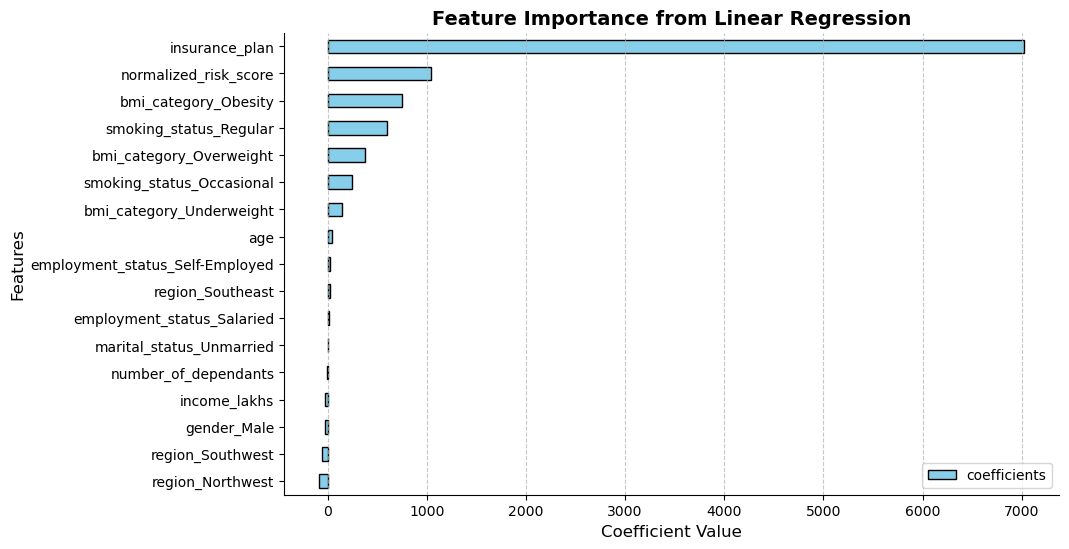

In [134]:
## feature importance
feature_importances=model_lr.coef_
coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Feature Importance from Linear Regression", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

### Key Features Identified by Linear Regression

From the **Linear Regression** model, we can determine feature importance by analyzing the **coefficients**. These coefficients tell us the relationship between each feature and the target variable.

### Key Insights:
- **Age** is no longer a significant contributor to the premium prediction for this young age group, as seen in the feature importance analysis.
- The most influential features in the model are:
  - **Insurance Plan**
  - **Normalized Risk Score**

These features have the highest absolute coefficient values, indicating they have a strong impact on predicting the premium. This highlights that the premium prediction for individuals aged 25 and under is primarily driven by factors like the type of insurance plan and the normalized risk score, rather than age itself.

Understanding these key predictors helps in making informed decisions and improving the model's interpretability for this age group.


### Hyperparameter Tuning and Model Evaluation

To improve model performance, we experiment with different regression models and compare their effectiveness.  

- We define a dictionary of models, including:
  - **Linear Regression**
  - **Lasso Regression** (L1 regularization)
  - **Ridge Regression** (L2 regularization)
  - **Decision Tree Regressor**
  - **Random Forest Regressor**
  - **XGBoost Regressor**

- Each model is trained using the **training dataset** and evaluated on the **test dataset**.
- We calculate:
  - **Train Score**: Measures how well the model fits the training data.
  - **Test Score**: Evaluates how well the model generalizes to unseen data.

By comparing these scores, we can identify the best-performing model and detect **overfitting** (if the train score is significantly higher than the test score).


In [135]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),  # You can adjust alpha
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')  # For regression tasks
}
train_scores = []
test_scores = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"{name} - Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")



Linear Regression - Train Score: 0.6067, Test Score: 0.5938
Ridge - Train Score: 0.6067, Test Score: 0.5938
Decision Tree - Train Score: 0.9821, Test Score: 0.1661
Random Forest - Train Score: 0.9248, Test Score: 0.5295
XGBoost - Train Score: 0.7293, Test Score: 0.5536


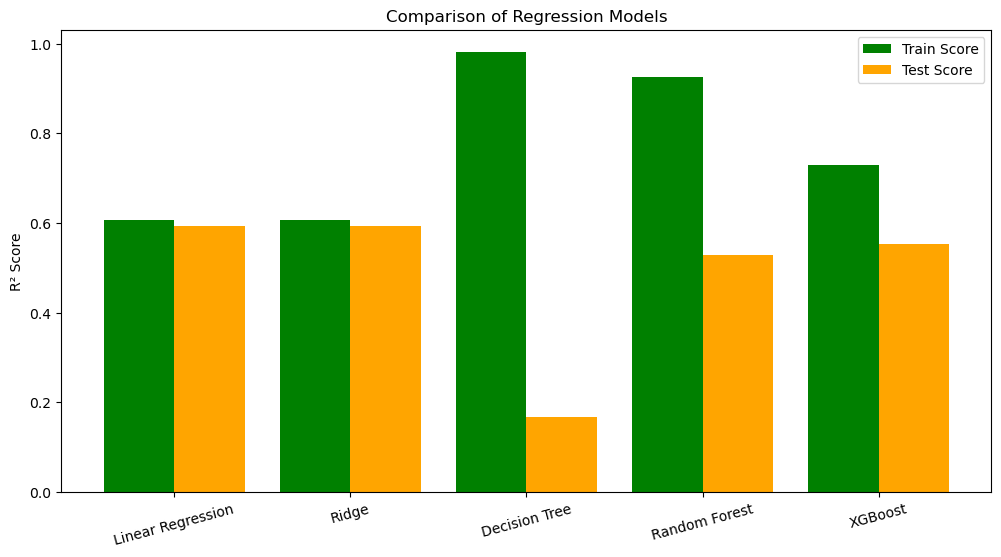

In [136]:
# Visualizing results
x_labels = list(models.keys())
x = np.arange(len(x_labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, train_scores, width=0.4, label="Train Score", color='green')
plt.bar(x + 0.2, test_scores, width=0.4, label="Test Score", color='orange')

plt.xticks(x, x_labels, rotation=15)
plt.ylabel("R² Score")
plt.title("Comparison of Regression Models")
plt.legend()
plt.show()

### Model Performance Summary

None of the models performed well for the **young age group (Age <= 25)**:

- **Linear Regression** provided the most consistent performance despite the relatively low scores:
  - Train Score: **0.6067**, Test Score: **0.5938**

- **Decision Tree** significantly overfitted:
  - Train Score: **0.9821**, Test Score: **0.1628**

- **Random Forest** and **XGBoost** performed better but still had moderate test scores:
  - Random Forest: Train Score: **0.9247**, Test Score: **0.5236**  
  - XGBoost: Train Score: **0.7293**, Test Score: **0.5536**

Given that no model performed significantly better, we have chosen to move forward with **Linear Regression**, as it offers the most stable results for this group, while also indicating that further model tuning, feature engineering, or data preprocessing may be necessary for improvement.


In [137]:

model_xgb=XGBRegressor()
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5]
}
random_search=RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2')
random_search.fit(X_train,y_train)
random_search.best_score_

0.6035155033080727

In [138]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [139]:
best_model=model_lr


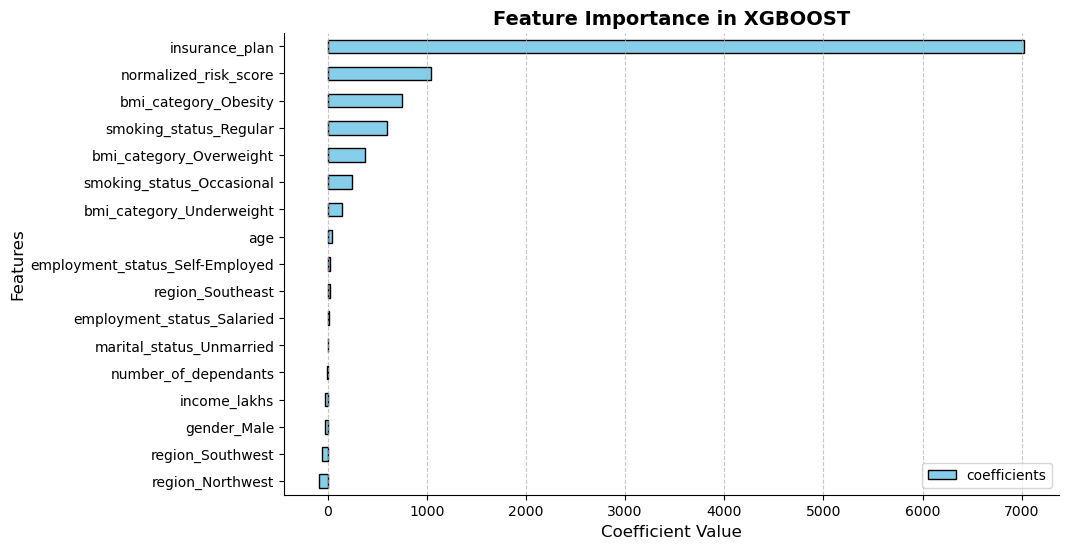

In [140]:
## feature importance
feature_importances=best_model.coef_

coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')


# Add title and labels
plt.title("Feature Importance in XGBOOST", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

###

---

## Error Analysis

To ensure our model is performing well:
- **Check Residuals**: Residual plots should show a random distribution without clear patterns.
- **Evaluate RMSE & MAE**: Lower values indicate better predictive performance.
- **Identify Outliers**: Extreme errors could indicate data inconsistencies or model weaknesses.
- **Check Bias & Variance**: Ensure the model balances bias (underfitting) and variance (overfitting).

By conducting thorough **error analysis**, we can validate whether the model is genuinely reliable and where improvements can be made.


In [141]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=(residuals*100)/y_test

results_df=pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'residuals':residuals,
    'diff_pct':residuals_pct
})
results_df.head()

,actual,predicted,residuals,diff_pct
3218,11980,10157.018713,-1822.981287,-15.216872
8672,5884,6422.425163,538.425163,9.150666
4144,9931,10075.349523,144.349523,1.453525
3397,7819,7326.438626,-492.561374,-6.299544
19747,16110,13394.877335,-2715.122665,-16.853648


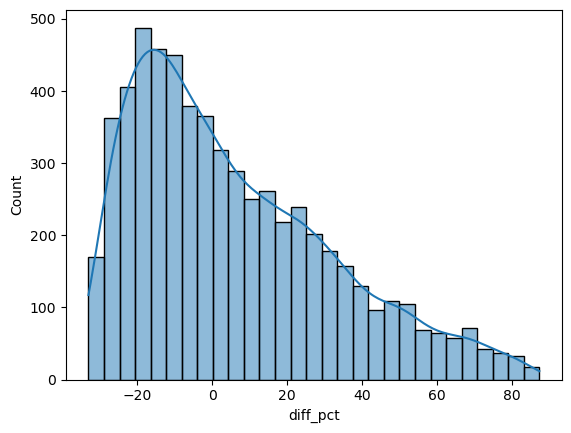

In [142]:
### visualise the residuals_pct

sns.histplot(results_df.diff_pct,kde=True)
plt.show()

In [143]:
### After enquiring to the team we are informed that we need to make sure the error % margin in just 10%

extreme_error_threshold=10
extreme_results_df=results_df[abs(results_df['diff_pct'])>extreme_error_threshold]
extreme_results_df.shape

(4403, 4)

In [144]:
results_df.shape

(6026, 4)

In [145]:
extreme_errors_pct=extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

73.06671091934949

In [146]:
results_df[abs(results_df['diff_pct'])>50].sort_values('diff_pct',ascending=False)


,actual,predicted,residuals,diff_pct
12058,3503,6558.771623,3055.771623,87.232990
641,3522,6590.265422,3068.265422,87.117133
17197,3508,6529.414344,3021.414344,86.129257
10288,3623,6740.105510,3117.105510,86.036586
3652,3536,6569.472694,3033.472694,85.788255
...,...,...,...,...
18783,4601,6908.344107,2307.344107,50.148753
19112,4361,6544.570838,2183.570838,50.070416
5022,4333,6502.449818,2169.449818,50.068078
577,4348,6524.929403,2176.929403,50.067374


In [147]:
# lets analyse in which subset of data this errors are hapening
# get more columns
X_test.index

Index([ 3218,  8672,  4144,  3397, 19747,  4305,  7319,   119,  8751,  6054,
       ...
       12298,  9512,  1189,  5573,  1001,   940, 10047,  6420, 18801,  6884],
      dtype='int64', length=6026)

In [148]:
extreme_errors_df=X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3218,0.142857,0.000000,0.858586,0.5,0.0,1,0,0,0,1,0,0,1,0,0,0,1
19747,0.000000,0.000000,0.989899,1.0,0.0,1,1,0,0,1,0,0,0,0,0,0,0
4305,0.714286,0.333333,0.080808,0.0,0.0,1,0,0,1,1,0,1,0,0,1,0,0
119,0.142857,0.000000,0.181818,0.0,0.0,0,0,1,0,1,0,0,0,0,0,1,0
8751,0.857143,0.000000,0.262626,0.0,0.0,0,0,1,0,1,0,0,1,0,0,0,0


### Comparing Error Distributions

Next, we compare the **distribution of features** in the subset of data with extreme errors against the original distribution of the entire dataset. By doing so, we aim to identify if there are specific features or subsets of the data where the model is underperforming.

We use **histograms with kernel density estimates (KDE)** to visualize and compare the distributions for each feature:
- **Overall distribution** of features from `X_test`.
- **Distribution of features** with extreme errors from `extreme_errors_df`.

This comparison allows us to pinpoint which features or data subsets contribute to the higher error margins, helping in identifying areas for model improvement.


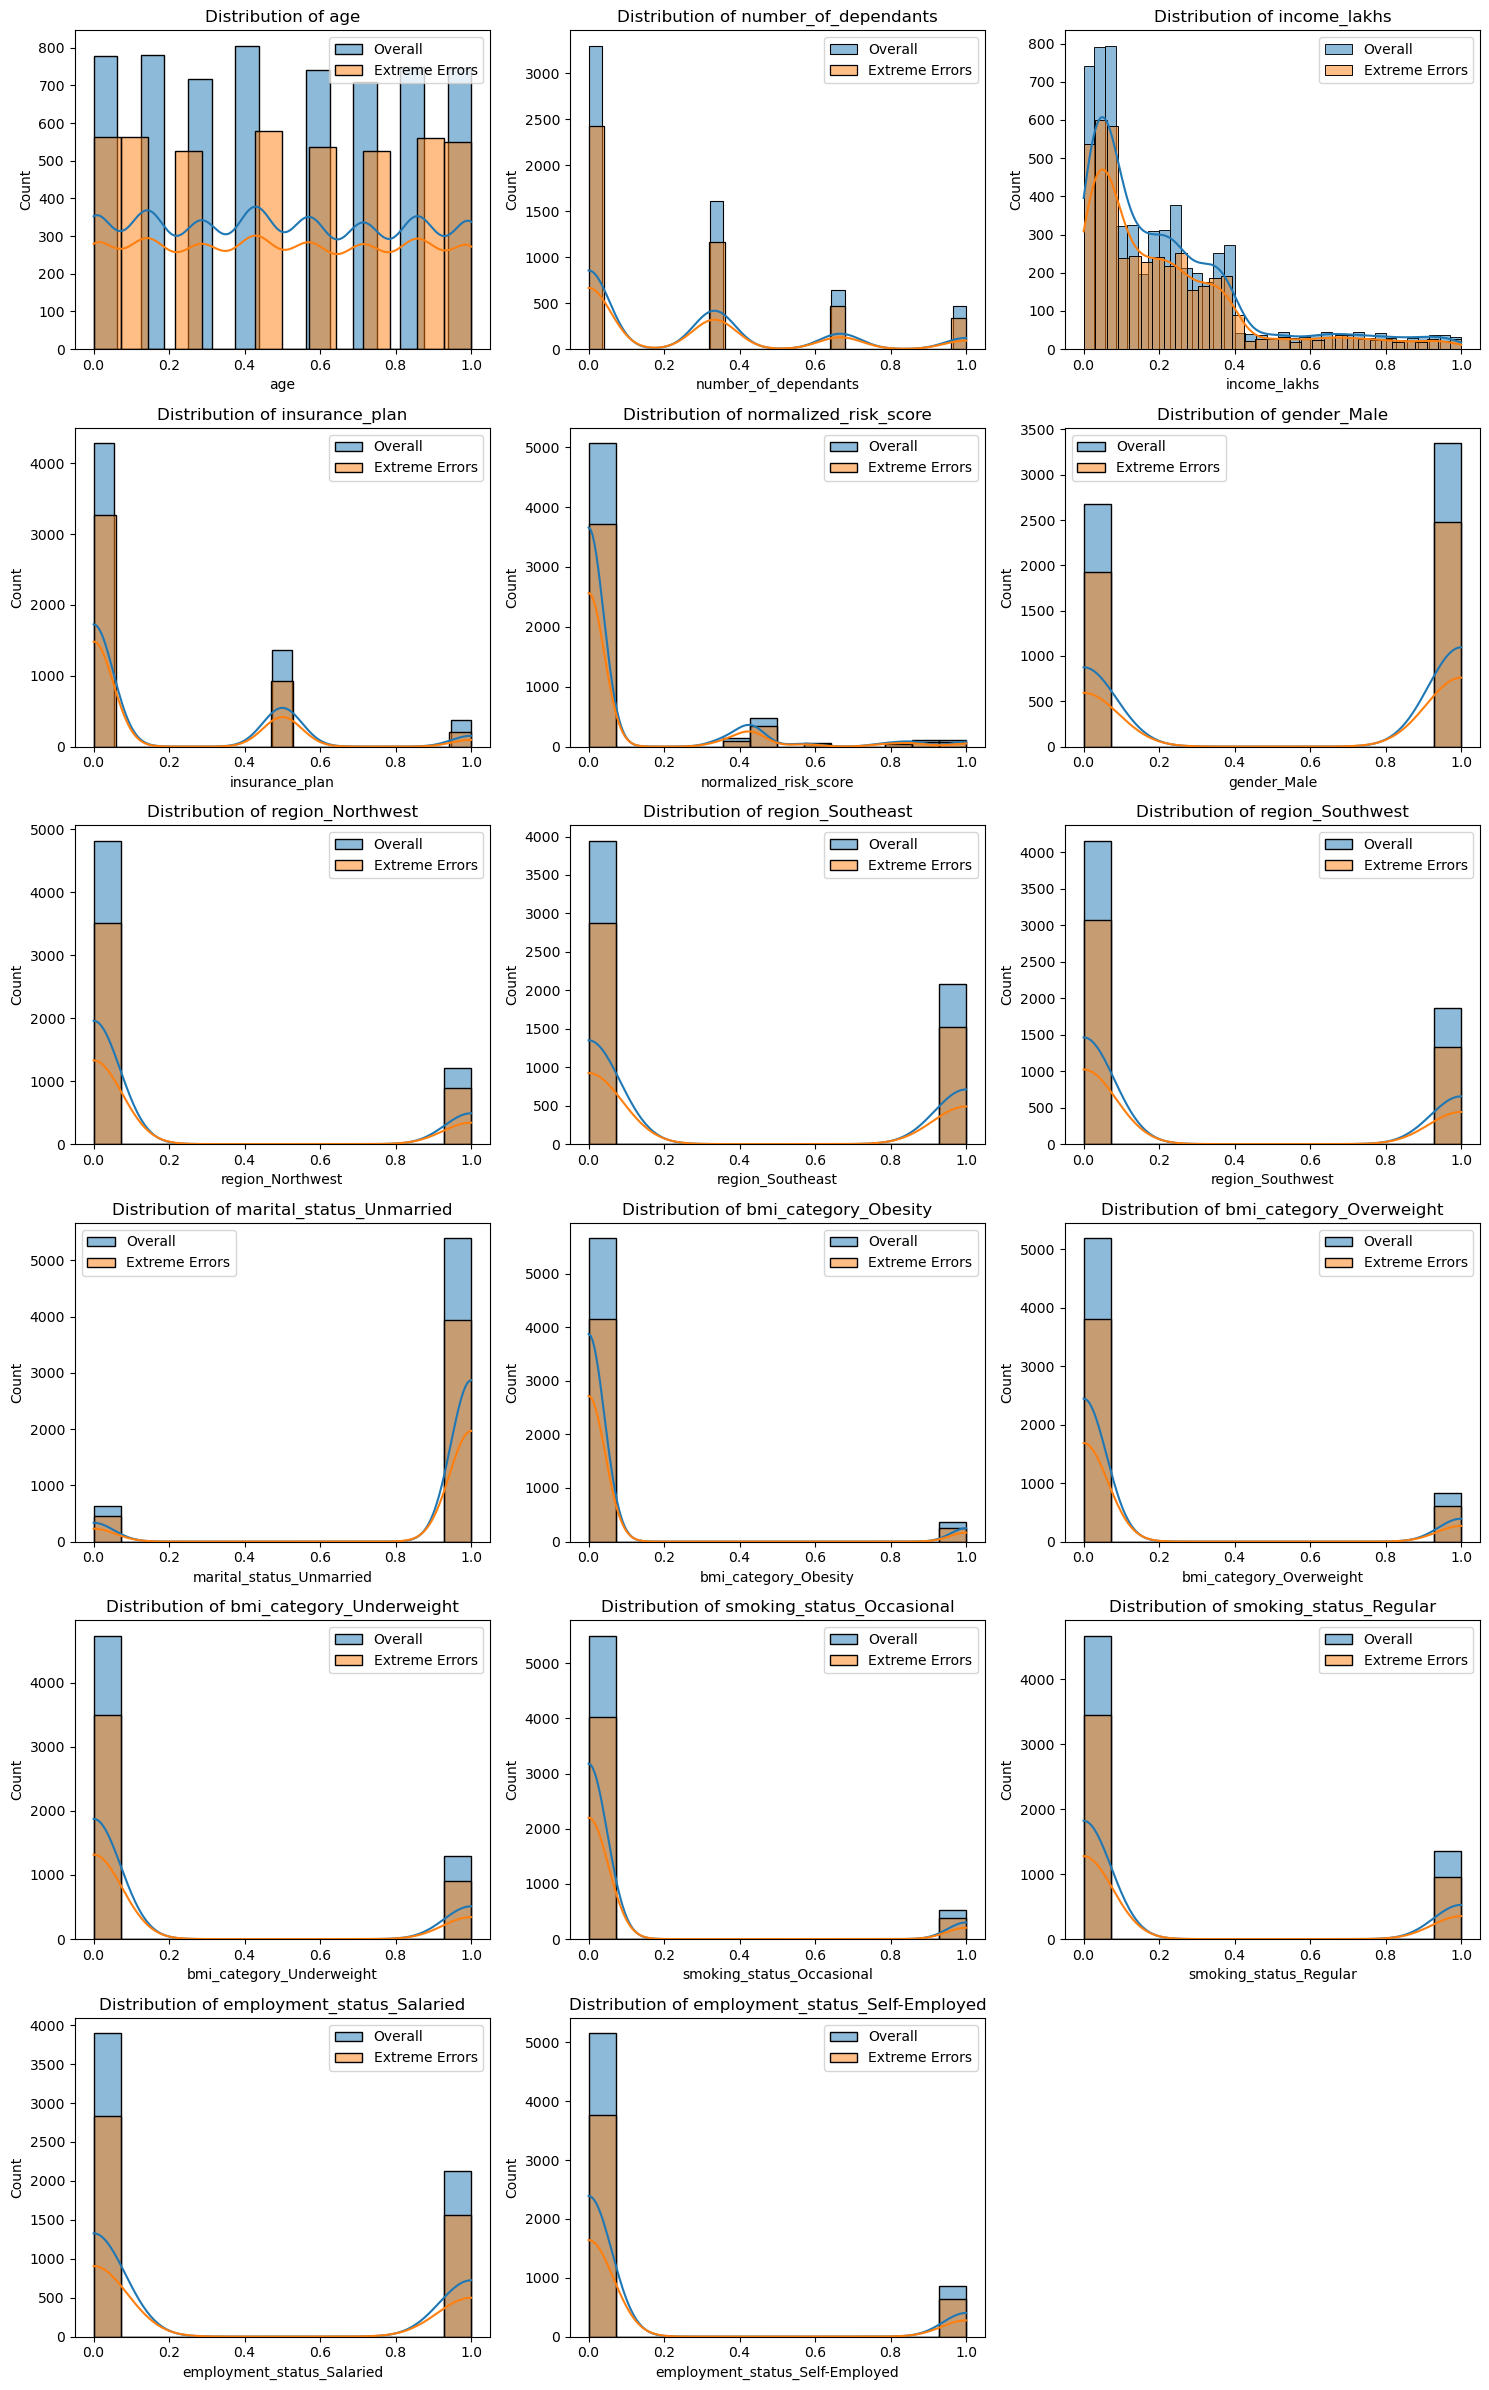

In [149]:
num_features = len(X_test.columns)
num_cols = 3  # You can adjust the number of columns
num_rows = int(np.ceil(num_features / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot each feature
for i, feature in enumerate(X_test.columns):
    ax = axes[i]
    sns.histplot(X_test[feature], label='Overall', kde=True, ax=ax)
    sns.histplot(extreme_errors_df[feature], label="Extreme Errors", kde=True, ax=ax)
    ax.legend()
    ax.set_title(f'Distribution of {feature}')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Optimizing the Model: Adding More Features

In order to optimize the model, we need more features and data. After some research, I have identified several factors that are contributing to the premium amount:

1. **Genetic Factor**  
2. **Lifestyle Factor**  
3. **Past Insurance Claims**

However, I was only able to get the **Genetic Factor** data from the support team at this point. Adding this feature to the model could help improve its predictive performance. The inclusion of other factors, such as Lifestyle and Past Insurance Claims, will be explored once data is available.

---

### Model Improvement: Adding Genetic Factor Data

I am improving the model by training it with the newly included **Genetic Factor** data in the updated notebook: `ml_premium_health_insurance_prediction_young_with_gr`. Hopping, This additional feature will help the model make more accurate predictions for the **young age group (Age <= 25)**. 

The model will be further optimized as more data becomes available, particularly for the **Lifestyle Factor** and **Past Insurance Claims**, which are expected to contribute significantly to the premium prediction.

